<a href="https://colab.research.google.com/github/blbailey/Blog_Code/blob/master/Copy_of_Homework_Assignment_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recursive technical homework

## Motivation
We hope you have fun doing this task as well as learn something new.

Do not be discouraged if you find the task challenging. Feel free to research as much as you want on Google or any other resource to solve this task. You are welcome to copy code snippets from stackoverflow, tutorials, blog posts, etc to help you finish the task. Make sure you understand them though :)

It is alright if you don't solve 100% of the tasks, the goal is to push yourself a little and see how you like solving new problems using scientific computing and data analysis.

**About colab**

Please create a duplicate of this notebook using File > Save a Copy in Drive. Share your solution via a link to your local copy of the notebook.

You can solve the entirety of this task using a free kernel running in the cloud. Just click 'Connect' on the top right of the notebook. You can use any python libraries you want *unless* explicitly told to code your own algorithm. If a library you want to use is not already available from the colab runtime, go to 'Help' > 'Search code snippets' > Type 'Importing a library that is not in Colab' to learn how to install a library using pip.

**About the code**
* The provided code uses PyTorch. Refer to the tutorial [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) if you need to learn more about PyTorch.
* You can also ignore the code below and implement this task in a library of your choice such as TensorFlow, JAX or others.

# Part 1
Understanding Stochastic Gradient Descent.
In this exercise, we want to implement [Stochastic Gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) without using a built-in optimizer, to understand how parameters are optimized at the low level.

Let's consider a toy problem of [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression). The data generation process is such that we have one floating point variable $x \in [0,1]$, and one categorical variable $y\in \{0,1\}$. The Logistic Regression problem is to find the optimal parameters for the logistic function to predict the probability of $y$ given $x$.

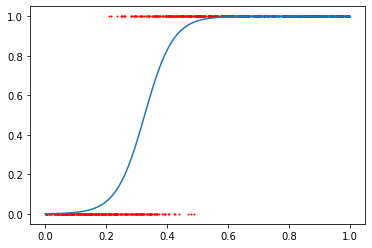

In the image above, the x and y axis correspond to the variables defined previously, with the red "dots" the true data as generated by the process defined below, and the blue line is the optimal logistic decision function learned from the data.

The optimal parameters can be found numerically using gradient descent. In this case, we will be using SGD (batched gradient descent) to optimize the two parameters in the logistic function, $\beta_1, \beta_2$.

If ${p(x)={\frac {1}{1+e^{-(\beta _{1}+\beta _{2}x)}}}}$, then we want to find $\beta_1, \beta_2$ such that the [negative log likelihood](https://en.wikipedia.org/wiki/Likelihood_function) is minimized. In this case, ${\ell =\sum _{k=1}^{K}\left(\,y_{k}\ln(p_{k})+(1-y_{k})\ln(1-p_{k})\right)}$, and the SGD formula is simply:
$\beta_i = \beta_{i-1} - \alpha * \nabla \ell$.

The data generation process as well as the pseudo-code is provided for you below, your task is to fill in the appropriate pytorch code. *Do not use the built-in optimizer*, implement SGD using tensor operations alone.


In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [6]:
def generate_data():
  data = torch.rand(1000, 2)
  label = ((data[:,0]+0.3*data[:,1]) > 0.5).to(torch.int)
  return data[:,0], label

tensor(-582.1383, grad_fn=<AddBackward0>)
tensor(-287.9764, grad_fn=<AddBackward0>)
tensor(-230.5086, grad_fn=<AddBackward0>)
tensor(-206.2216, grad_fn=<AddBackward0>)
tensor(-192.7776, grad_fn=<AddBackward0>)


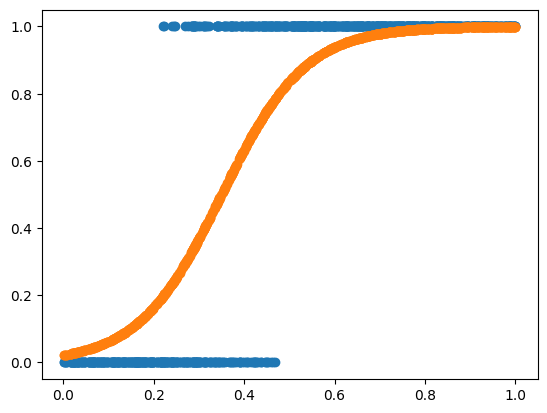

In [7]:
input, label = generate_data()

# Make minibatches.
inputs = torch.split(input, 10)
labels = torch.split(label, 10)

# Define the two variables to optimize
b1 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)
b2 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)

lr=0.01

for epoch in range(50):
  loss=0
  for x, y in zip(inputs,labels):
    # Calculate p_x as per formula above
    p_x=1/(1+torch.exp(-(b1+b2*x)))
    # Calculate the negative loss likelihood
    l_batch=torch.sum(y*torch.log(p_x)+(1-y)*torch.log(1-p_x))
    # Calculate the gradient of the loss w.r.t. the inputs
    grad_b1=-torch.sum(y-p_x)
    grad_b2=-torch.sum((y-p_x)*x)
    # Update the parameters b according to SGD formula
    b1=b1-lr*grad_b1
    b2=b2-lr*grad_b2
    # Print out the loss value
    loss+=l_batch
  if epoch%10==0:
    print(loss)
# Reproduce the image above to validate your result.
label_forecast = 1 / (1 + torch.exp(-(b1 + b2 * input)))
label_forecast_numpy = label_forecast.detach().numpy()
plt.figure()
plt.plot(input, label, "o")
plt.plot(input, label_forecast_numpy,'o')
plt.show()




# Part 2

Researchers have measured a bivariate timeseries, but the equipment was unreliable so the data has gaps as well as noise. The data can be found in [data.csv](https://gist.github.com/tmramalho/51733432c88e2b834dbd70353849f887)

In this exercise, we want to train an [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) to regress the full observed trajectory from the measured data. Formally, the MLP will be used to approximate the function $f:\mathbb{R} \rightarrow \mathbb{R}^2 ; f(t) = (x(t), y(t))$. In other words, the model takes the current time as an input, and predicts the values of `x` and `y` at that time based only on the measured data.

Your task is to define the data loader, the MLP model and the loss function to complete this task successfully. For this problem you will need to use a regression loss, not a classification loss.

Successful training should result in a data interpolation similar to the below:
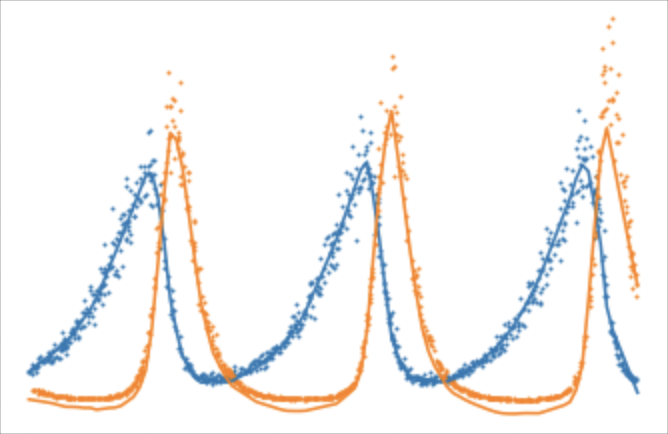

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

In [9]:
class Net(nn.Module):
    '''Model to regress 2d time series values given scalar input.'''
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # Input size: 1, Output size: 64
        self.fc2 = nn.Linear(64, 64)  # Input size: 64, Output size: 64
        self.fc3 = nn.Linear(64, 64)  # Input size: 64, Output size: 64
        self.fc4 = nn.Linear(64, 2)  # Input size: 64, Output size: 2 (for 2D output)


    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))  # Apply ReLU activation to the output of first linear layer
        x = nn.functional.tanh(self.fc2(x))  # Apply ReLU activation to the output of second linear layer
        x = nn.functional.tanh(self.fc3(x))  # Apply ReLU activation to the output of second linear layer
        x = self.fc4(x)  # Final linear layer for output
        return x

In [10]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
        df = pd.read_csv(csv_file).replace('-', float('nan')).dropna().astype('float')
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()
      t_tensor = torch.tensor(self.data.iloc[idx, 0], dtype=torch.float32) # Time step
      x_y_values = self.data.iloc[idx, 1:3].values  # Extract 'x' and 'y' values from the DataFrame
      xy_tensor = torch.tensor(x_y_values, dtype=torch.float32)  # Convert to PyTorch tensor

      return t_tensor, xy_tensor

In [89]:
df=pd.read_csv('/content/sample_data/data.csv').replace('-', float('nan')).dropna().astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 327 entries, 4 to 1987
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       327 non-null    float64
 1   x       327 non-null    float64
 2   y       327 non-null    float64
dtypes: float64(3)
memory usage: 10.2 KB


In [11]:
dataset = TimeSeriesDataset('/content/sample_data/data.csv')
BATCH_SIZE=len(dataset)
rate_learning=0.01
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

def loss_fn(outputs, labels):
  return F.mse_loss(outputs, labels)

net = Net()
optimizer = optim.Adam(net.parameters(), lr=rate_learning)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.constant_(m.bias, 0.1)

net.apply(init_weights)


Net(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
)

In [12]:
for epoch in range(500):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # print(inputs.unsqueeze(1).shape)
        # forward + backward + optimize
        outputs = net(inputs.unsqueeze(1))
        # print(outputs.shape)
        loss = loss_fn(outputs, labels)
        # print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 1:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished Training


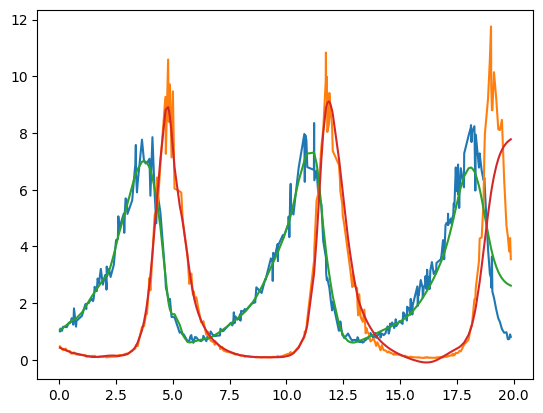

In [13]:
import matplotlib.pyplot as plt

# Plot results to validate training
dataset = TimeSeriesDataset('/content/sample_data/data.csv')
data_t=torch.tensor(dataset.data["t"].to_numpy(),dtype=torch.float32).unsqueeze(1)
forecast_xy=net(data_t)
plt.figure()
plt.plot(dataset.data["t"].to_numpy(), dataset.data[["x", "y"]].to_numpy()) # training dataset
plt.plot(dataset.data["t"].to_numpy(), forecast_xy.detach().numpy()) # forecast dataset
plt.show()



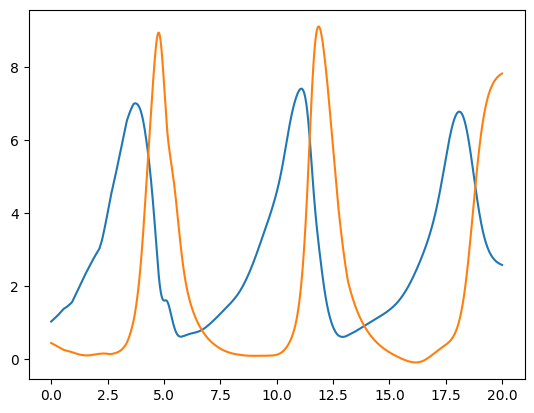

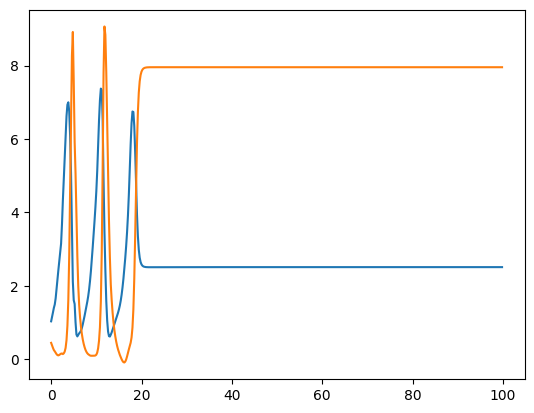

In [14]:
df_raw=pd.read_csv('/content/sample_data/data.csv')
raw_t=torch.tensor(df_raw["t"].to_numpy(),dtype=torch.float32).unsqueeze(1)
forecast_raw_xy=net(raw_t)

plt.figure()
plt.plot(df_raw["t"].to_numpy(), forecast_raw_xy.detach().numpy()) # forecast dataset
plt.show()

import numpy as np
expo_t=torch.tensor(np.arange(0,100,0.2), dtype=torch.float32).unsqueeze(1)
expo_forecast_xy=net(expo_t)


plt.figure()
plt.plot(expo_t, expo_forecast_xy.detach().numpy()) # forecast dataset
plt.show()


### Time-series extension [optional]

The simplified model above will only work well if $t\in[0,20]$.
Create a different model that can extrapolate `x,y` predictions to $t>20$.
Assume that the model has access to the same data as above, and is tasked to predict up to $t=100$. You can change anything in the above setup as needed, including model architecture, loss function, training procedure or data loader.

There are several different correct approaches to tackle this problem, all with different pros and cons, so make sure to explain your reasoning for the different choices made.


In [59]:
def mock_data(noise=False):
  df_raw=pd.read_csv('/content/sample_data/data.csv')
  raw_t=torch.tensor(df_raw["t"].to_numpy(),dtype=torch.float32).unsqueeze(1)
  forecast_raw_xy=net(raw_t)

  dataset = TimeSeriesDataset('/content/sample_data/data.csv')
  data_t=torch.tensor(dataset.data["t"].to_numpy(),dtype=torch.float32).unsqueeze(1)
  data_xy = torch.tensor(dataset.data[["x","y"]].to_numpy(), dtype=torch.float32)

  forecast_xy=net(data_t)

  # create data by copying the forecasts
  t_20_above=torch.tensor(np.arange(20,100,0.01), dtype=torch.float32).unsqueeze(1)
  xy_above=forecast_raw_xy.repeat(4,1)

  selected_idx=list(np.sort(np.random.randint(low=0, high=8000, size=800)))

  t_20_above_sel=t_20_above[selected_idx]
  xy_above_sel=xy_above[selected_idx,:]



  if noise:

      std = torch.std(data_xy-forecast_xy)
      xy_noise = torch.randn_like(xy_above_sel) * std/3 + 0
      xy_above_sel=xy_above_sel+xy_noise

  t_concat = torch.cat((data_t, t_20_above_sel), dim=0)  # Concatenate along the first dimension (rows)
  xy_concat=torch.cat((data_xy, xy_above_sel), dim=0)

  # merge t_concat and xy_concat
  data_concat=torch.cat((t_concat, xy_concat), dim=1)

  df_data = pd.DataFrame(data_concat.detach().numpy(), columns=['t', 'x', 'y'])

  df_data.to_csv("/content/sample_data/data_mocked.csv")

mock_data()







In [62]:
dataset = TimeSeriesDataset('/content/sample_data/data_mocked.csv')
BATCH_SIZE=len(dataset)
print(BATCH_SIZE)
rate_learning=0.01
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

def loss_fn(outputs, labels):
  return F.mse_loss(outputs, labels)

net_100 = Net()
optimizer = optim.Adam(net_100.parameters(), lr=rate_learning)

net_100.apply(init_weights)

for epoch in range(1000):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # print(inputs.unsqueeze(1).shape)
        # forward + backward + optimize
        outputs = net_100(inputs.unsqueeze(1))
        # print(outputs.shape)
        loss = loss_fn(outputs, labels)
        # print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 1:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

1127


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished Training


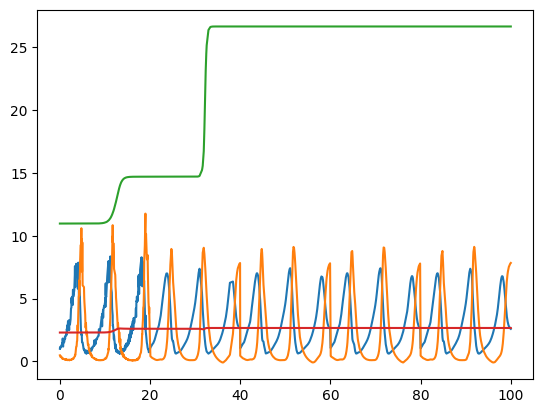

In [63]:
import matplotlib.pyplot as plt

# Plot results to validate training
dataset = TimeSeriesDataset('/content/sample_data/data_mocked.csv')
data_t=torch.tensor(dataset.data["t"].to_numpy(),dtype=torch.float32).unsqueeze(1)
forecast_xy=net_100(data_t)
plt.figure()
plt.plot(dataset.data["t"].to_numpy(), dataset.data[["x", "y"]].to_numpy()) # training dataset
plt.plot(dataset.data["t"].to_numpy(), forecast_xy.detach().numpy()) # forecast dataset
plt.show()


# Part 3

Please implement the below function `min_dist`. This function should take a sparse list of 2D coordinates, and map them to a 2D tensor of a specified resolution. The values of each pixel in the tensor should correspond to the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between that pixel and the closest pixel which contains a data point.

You can use either numpy or pytorch tensor operations to implement the function. Use only tensor operations, no for-loops are necessary.

Here are the example outputs for the two test cases highlighted below:

Case 1: data at `[0.4, 0.3], [0.6, 0.7]`, resolution 20 pixels.

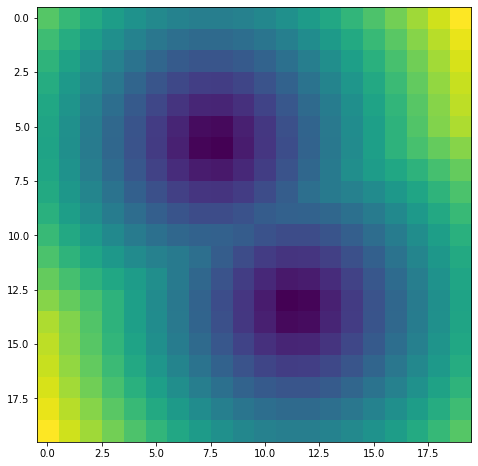


Case 2: data at `[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]`, resolution 256 pixels.

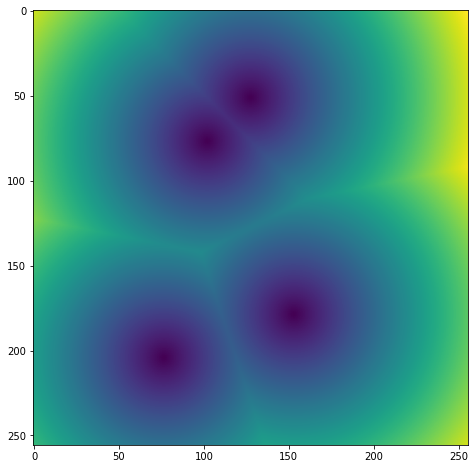


In [ ]:
def min_dist(points, res):
  """Calculates a 2D tensor with the minimum distance from each pixel to data.

  Inputs:
    * points: a python list of 2D coordinates, normalized in the range [0,1]
    * res: the resolution of the output tensor.
  Returns:
    A res x res square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points.
  """


In [ ]:
# Case 1:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7]], 20)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

In [ ]:
# Case 2:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]], 256)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

### Batched version

As a next step, improve the `min_dist` function to support batches.
The `points` array is now expected to be a tensor with shape [batch_size, num_points, 3], generated by `create_points`.
`min_dist` should return a batch of maps with shape [batch_size, res, res].
Again, make sure to implement `min_dist` using **no for-loops**.
Demonstrate your function output with `batch_size=3` and `num_points=4`.

In [ ]:
def create_points(batch_size, num_points):
  coords = np.random.rand(batch_size, num_points, 2)
  values = np.random.randint(0, 10, batch_size*num_points).reshape(batch_size, num_points)
  values = np.expand_dims(values, 2)
  points = np.concatenate((coords, values), axis=2)
  return points

In [ ]:
def min_dist(points, res):
  """Calculates a 3D tensor with the minimum distance from each pixel to data.

  Inputs:
    * points: a numpy array of 2D coordinates and point values, normalized to
              be in the range [0,1]. The expected shape is [B, P, 3].
    * res: the resolution of the output tensor.
  Returns:
    A res x res square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points. The return tensor
    shape is [B, res, res].
  """

### Scalable version [optional]

Assume `res` can be very large (up to 65,536). Running the above function will likely cause the computer's RAM to be filled up, and fail (on a free colab instance, even 16,384 `res` will crash with `batch_size=3` and `num_points=4`).
Extend the above version of `min_dist` to calculate the result tensor at such high resolution without running out of RAM. This function may be less computationally efficient, as long as it can successfully run.